### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm

In [2]:
users_df = pd.read_csv('users.csv')
activities_df = pd.read_csv('activities.csv')

### Data understanding

In [3]:
users_df.head()

,UserId,Country,DOB,Gender,RegDate
0,1326865,DE,1988-05-04,M,2016-03-24
1,1333278,GB,1971-07-21,M,2016-02-09
2,1336967,GB,1983-07-31,M,2016-01-29
3,1339784,Other,1976-09-21,M,2016-01-21
4,1339829,Other,1981-05-03,F,2016-04-12


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5807 entries, 0 to 5806
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   UserId   5807 non-null   int64 
 1   Country  5807 non-null   object
 2   DOB      5807 non-null   object
 3   Gender   5807 non-null   object
 4   RegDate  5807 non-null   object
dtypes: int64(1), object(4)
memory usage: 227.0+ KB


In [5]:
print(users_df['Country'].unique())
print(users_df['Gender'].unique())

['DE' 'GB' 'Other' 'FR' 'US']
['M' 'F' ' ']


In [6]:
activities_df.head()

,UserId,Date,Revenue
0,1326865,2017-02-19,17.05
1,1326865,2017-02-28,17.05
2,1326865,2017-03-06,17.16
3,1326865,2017-03-07,17.16
4,1326865,2017-03-08,17.16


In [7]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22642 entries, 0 to 22641
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UserId   22642 non-null  int64  
 1   Date     22642 non-null  object 
 2   Revenue  22642 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 530.8+ KB


#### <span style='color:red'> A - 1 </span>
a: 5 variables in users table and 3 variables in activities table

b: 5807 records in users table and 22642 records in activities table

ps. days_since_reg is not available

In [8]:
print('Male users: ', len(users_df[users_df['Gender']=='M']))
print('Female users: ', len(users_df[users_df['Gender']=='F']))
print('other: ', len(users_df[users_df['Gender']==' ']))

Male users:  2909
Female users:  1417
other:  1481


#### <span style='color:red'> A - 2 </span>
a: Male users:  2909

b: Female users:  1417

c: other:  1481


In [9]:
users_df['Gender'].replace(' ', 'M', inplace = True)

In [10]:
print('other: ', len(users_df[users_df['Gender']==' ']))

other:  0


In [11]:
print(len(users_df['UserId'].unique()))
print(len(activities_df['UserId'].unique())) #after caclulating revenue per user I noticed a difference so I added this check

5807
5797


## Data manipulation

#### <span style='color:red'> A - 3 </span>

In [12]:
activities_df = activities_df.merge(users_df, on = 'UserId')

In [13]:
activities_df.head()

,UserId,Date,Revenue,Country,DOB,Gender,RegDate
0,1326865,2017-02-19,17.05,DE,1988-05-04,M,2016-03-24
1,1326865,2017-02-28,17.05,DE,1988-05-04,M,2016-03-24
2,1326865,2017-03-06,17.16,DE,1988-05-04,M,2016-03-24
3,1326865,2017-03-07,17.16,DE,1988-05-04,M,2016-03-24
4,1326865,2017-03-08,17.16,DE,1988-05-04,M,2016-03-24


In [14]:
activities_df[['Date','RegDate','DOB']] = activities_df[['Date','RegDate','DOB']].apply(pd.to_datetime)
activities_df['days_since_reg'] = (activities_df['Date'] - activities_df['RegDate']).dt.days
activities_df['Week'] = activities_df['days_since_reg'] // 7 + 1

# it might be that someone's birthday in their first week, so important not to create two week1 records for regression part:
activities_df['Registration_Age'] = activities_df.apply(lambda x: relativedelta(x.RegDate, x.DOB).years, axis=1)


In [15]:
activities_df.head(5)

,UserId,Date,Revenue,Country,DOB,Gender,RegDate,days_since_reg,Week,Registration_Age
0,1326865,2017-02-19,17.05,DE,1988-05-04,M,2016-03-24,332,48,27
1,1326865,2017-02-28,17.05,DE,1988-05-04,M,2016-03-24,341,49,27
2,1326865,2017-03-06,17.16,DE,1988-05-04,M,2016-03-24,347,50,27
3,1326865,2017-03-07,17.16,DE,1988-05-04,M,2016-03-24,348,50,27
4,1326865,2017-03-08,17.16,DE,1988-05-04,M,2016-03-24,349,50,27


In [16]:
activities_df[activities_df['Week'] == 1] #Not everyone starts at week 1!

,UserId,Date,Revenue,Country,DOB,Gender,RegDate,days_since_reg,Week,Registration_Age
1642,3109386,2017-03-03,20.00,GB,1986-05-16,F,2017-02-26,5,1,30
1647,3114216,2017-01-29,29.19,Other,1978-09-02,M,2017-01-23,6,1,38
1652,3114891,2017-01-19,20.00,GB,1968-03-23,M,2017-01-16,3,1,48
1654,3115043,2016-10-22,17.05,US,1985-11-01,F,2016-10-17,5,1,30
1658,3115226,2016-12-04,25.00,GB,1967-07-04,M,2016-11-29,5,1,49
...,...,...,...,...,...,...,...,...,...,...
22633,3347222,2017-03-23,19.28,FR,1967-05-25,M,2017-03-22,1,1,49
22638,3347251,2017-04-03,30.00,GB,1981-06-11,F,2017-04-03,0,1,35
22639,3347333,2017-01-27,30.00,GB,1987-11-22,M,2017-01-27,0,1,29
22640,3347367,2017-04-04,17.05,US,1995-08-09,F,2017-04-04,0,1,21


In [17]:
temp_df = activities_df.groupby(['UserId','Week']).agg(Count = ('UserId','count')).reset_index()
temp_df[temp_df['Count']>1].head(5) # multiple pay per week is possible

,UserId,Week,Count
2,1326865,50,3
5,1326865,54,3
22,1361182,47,2
24,1361182,50,2
26,1405503,47,2


In [18]:
UserRevenue_df = activities_df.groupby('UserId').agg(
    MeanRevenue = ('Revenue', 'mean'), 
    MedianRevenue = ('Revenue', 'median'),
    StandardDeviation = ('Revenue', 'std'),
    MaxWeek = ('Week', 'max')).reset_index()

In [19]:
UserRevenue_df['MeanMedianDifference'] = UserRevenue_df['MeanRevenue'] - UserRevenue_df['MedianRevenue']

In [20]:
print(len(UserRevenue_df))
UserRevenue_df.head(10)

5797


,UserId,MeanRevenue,MedianRevenue,StandardDeviation,MaxWeek,MeanMedianDifference
0,1326865,18.495789,17.160,4.030674,79,1.335789
1,1333278,22.500000,22.500,3.535534,68,0.000000
2,1336967,20.000000,20.000,NaN,46,0.000000
3,1339784,29.640000,29.640,0.636396,50,0.000000
4,1339829,17.050000,17.050,NaN,45,0.000000
5,1346806,17.050000,17.050,NaN,49,0.000000
6,1361182,20.000000,20.000,0.000000,50,0.000000
7,1392534,46.900000,46.900,NaN,46,0.000000
8,1405503,21.605000,21.605,5.352798,47,0.000000
9,1415290,25.000000,20.000,12.247449,88,5.000000


In [21]:
UserRevenue_df[UserRevenue_df['MeanMedianDifference'] != 0]

,UserId,MeanRevenue,MedianRevenue,StandardDeviation,MaxWeek,MeanMedianDifference
0,1326865,18.495789,17.160,4.030674,79,1.335789
9,1415290,25.000000,20.000,12.247449,88,5.000000
15,1629211,82.927451,50.000,87.303107,77,32.927451
19,1728899,14.043333,12.400,3.488500,43,1.643333
22,1738641,33.333333,40.000,11.547005,60,-6.666667
...,...,...,...,...,...,...
5776,3346114,289.200000,240.000,219.301619,2,49.200000
5779,3346247,144.290455,109.415,129.811679,16,34.875455
5787,3346959,1033.333333,1000.000,950.438495,4,33.333333
5788,3346966,26.666667,20.000,11.547005,9,6.666667


In [22]:
print(len(UserRevenue_df[UserRevenue_df['MeanMedianDifference'] < 0]))
print(len(UserRevenue_df[UserRevenue_df['MeanMedianDifference'] > 0])) #In most cases mean is bigger

312
1556


##### Just to give a view of my thought process I included following individual check. I usually take a look at examples individual level data as well to have a better feeling of how the data looks like:

In [23]:
activities_df[activities_df['UserId'] == 3346247] 

,UserId,Date,Revenue,Country,DOB,Gender,RegDate,days_since_reg,Week,Registration_Age
22592,3346247,2017-05-02,21.32,Other,1972-08-03,F,2017-05-02,0,1,44
22593,3346247,2017-05-03,107.27,Other,1972-08-03,F,2017-05-02,1,1,44
22594,3346247,2017-05-04,68.65,Other,1972-08-03,F,2017-05-02,2,1,44
22595,3346247,2017-05-06,21.45,Other,1972-08-03,F,2017-05-02,4,1,44
22596,3346247,2017-05-07,25.74,Other,1972-08-03,F,2017-05-02,5,1,44
22597,3346247,2017-05-09,175.92,Other,1972-08-03,F,2017-05-02,7,2,44
22598,3346247,2017-05-10,85.81,Other,1972-08-03,F,2017-05-02,8,2,44
22599,3346247,2017-05-11,21.45,Other,1972-08-03,F,2017-05-02,9,2,44
22600,3346247,2017-05-12,85.81,Other,1972-08-03,F,2017-05-02,10,2,44
22601,3346247,2017-05-19,111.56,Other,1972-08-03,F,2017-05-02,17,3,44


<AxesSubplot:xlabel='Revenue', ylabel='Count'>

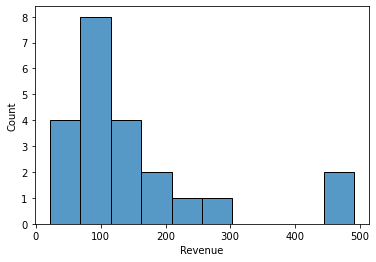

In [24]:
sns.histplot(data= activities_df[activities_df['UserId'] == 3346247] , x = 'Revenue', bins = 10) 

In [25]:
print('total mean: ', UserRevenue_df['MeanRevenue'].sum())
print('total median: ', UserRevenue_df['MedianRevenue'].sum())
print('total standard deviation: ', UserRevenue_df['StandardDeviation'].sum())

total mean:  592714.9532782566
total median:  530668.58
total standard deviation:  273879.53397269035


#### <span style='color:red'> A - 3 (mean median interpretation) </span>

Considering mean and median relationship (both per user and total per user) and the high standard deviation, I interpret the revenue per user to be skewed.

#### <span style='color:red'> A - 4 </span>


<AxesSubplot:xlabel='Revenue', ylabel='Count'>

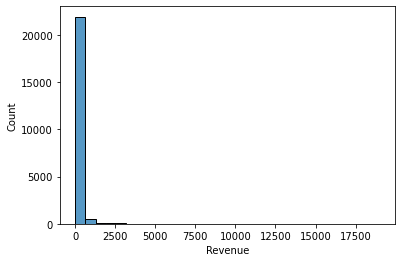

In [26]:
sns.histplot(data= activities_df, x = 'Revenue', bins=30) # the data is skewed as expected

<AxesSubplot:xlabel='Revenue', ylabel='Count'>

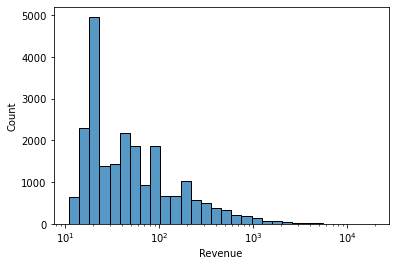

In [27]:
sns.histplot(data= activities_df, x = 'Revenue', bins=30, log_scale = True) 
# It is so heavily skewed that even on log sclale we can still see a tail

<AxesSubplot:xlabel='Revenue', ylabel='Count'>

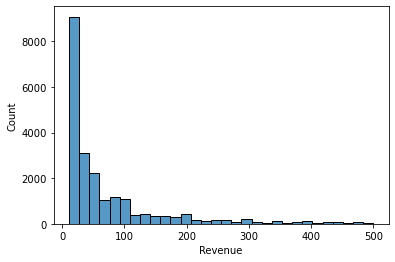

In [28]:
sns.histplot(data= activities_df[activities_df['Revenue']<500], x = 'Revenue', bins=30, log_scale = False)
# having a better view by limiting larger values.

#### <span style='color:red'> A - 5 </span>


In [29]:
week1_df = activities_df[activities_df['Week'] == 1].groupby(['UserId','Gender','Country','Registration_Age']).agg(
    MeanRevenue = ('Revenue', 'mean'),
    Revenue = ('Revenue', 'sum')).reset_index()

In [30]:
print(len(week1_df))
week1_df.head(5)

5089


,UserId,Gender,Country,Registration_Age,MeanRevenue,Revenue
0,3109386,F,GB,30,20.00,20.00
1,3114216,M,Other,38,29.19,29.19
2,3114891,M,GB,48,20.00,20.00
3,3115043,F,US,30,17.05,17.05
4,3115226,M,GB,49,25.00,25.00


In [31]:
print('Average week 1 revenue', week1_df['MeanRevenue'].mean())

Average week 1 revenue 114.48679338255243


#### <span style='color:red'> 6 </span>


In [32]:
ranksums(week1_df[week1_df['Gender']=='M']['MeanRevenue'], week1_df[week1_df['Gender']=='F']['MeanRevenue'])

RanksumsResult(statistic=4.285077451758108, pvalue=1.826755364975752e-05)

Using wilxocon test for independent samples, it appears the difference is statistically significant.

In [33]:
week1_perCountry_df = week1_df.groupby(['Gender','Country']).agg(
    MeanRevenue = ('MeanRevenue', 'mean')).reset_index()

In [34]:
week1_perCountry_df.head(5)

,Gender,Country,MeanRevenue
0,F,DE,70.421337
1,F,FR,119.435962
2,F,GB,120.894037
3,F,Other,54.977088
4,F,US,88.227154


#### <span style='color:red'> 7 </span>
At first sight it might seem the highest difference is in US, but given the average revenue per country is quite different, taking the ratio of female to male revenue is a better idea. In which case, 'Other' has the lowest ratio!

In [35]:
week1_perCountry_pivoted_df = week1_perCountry_df.pivot(index= 'Country', columns= ['Gender'], 
                          values = 'MeanRevenue').rename_axis(columns = None).reset_index()
week1_perCountry_pivoted_df['Difference'] = week1_perCountry_pivoted_df['F'] - week1_perCountry_pivoted_df['M']
week1_perCountry_pivoted_df['Ratio'] = week1_perCountry_pivoted_df['F'] / week1_perCountry_pivoted_df['M']
week1_perCountry_pivoted_df

,Country,F,M,Difference,Ratio
0,DE,70.421337,90.907424,-20.486087,0.774649
1,FR,119.435962,152.794811,-33.358849,0.781676
2,GB,120.894037,129.948952,-9.054915,0.930319
3,Other,54.977088,88.344157,-33.367069,0.622306
4,US,88.227154,125.875804,-37.648651,0.700906


#### <span style='color:red'> 8 </span>
Following par plot shows the relationship between country, gender, and week 1 revenue.

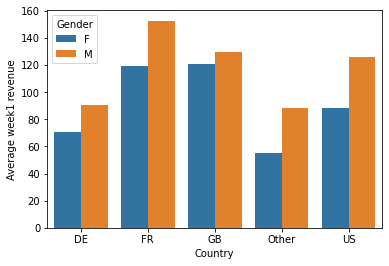

In [36]:
ax = sns.barplot(x="Country", y="MeanRevenue", hue="Gender", data=week1_perCountry_df)
ax.set(ylabel='Average week1 revenue')
plt.show()

#### <span style='color:red'> 9 </span>
I need to find first day revenue for the regression first.

In [37]:
FirstDay_df = activities_df[activities_df.Date == activities_df.RegDate][['UserId','Revenue']]
FirstDay_df.rename(columns={"Revenue": "FirstDayRevenue"}, inplace = True)
FirstDay_df.head(5)

,UserId,FirstDayRevenue
1761,3133634,42.63
1764,3133644,20.00
1765,3133648,40.00
1767,3133667,62.36
1773,3133694,20.25


In [38]:
print(len(week1_df))
week1_df = week1_df.merge(FirstDay_df, on = 'UserId') # inner join! not everyone has worked on the first day!
print(len(week1_df))
week1_df.head(5)

5089
4843


,UserId,Gender,Country,Registration_Age,MeanRevenue,Revenue,FirstDayRevenue
0,3133634,M,US,50,42.63,42.63,42.63
1,3133644,F,GB,27,20.00,20.00,20.00
2,3133648,M,GB,47,40.00,40.00,40.00
3,3133667,M,DE,30,62.36,62.36,62.36
4,3133694,M,GB,28,20.25,20.25,20.25


In [39]:
model_df = week1_df[['Gender', 'Registration_Age','Country', 'FirstDayRevenue', 'Revenue']].copy()
model_df['Male'] = model_df['Gender'].replace({'M': '1', 'F': '0'})
model_df['Male'] = model_df['Male'].astype(int)
model_df['Revenue'] = np.log(model_df['Revenue'])
model_df['FirstDayRevenue'] = np.log(model_df['FirstDayRevenue'])
model_df = pd.get_dummies(model_df, columns = ['Country'], prefix='', prefix_sep='')

model_df.head(5)

,Gender,Registration_Age,FirstDayRevenue,Revenue,Male,DE,FR,GB,Other,US
0,M,50,3.752558,3.752558,1,0,0,0,0,1
1,F,27,2.995732,2.995732,0,0,0,1,0,0
2,M,47,3.688879,3.688879,1,0,0,1,0,0
3,M,30,4.132924,4.132924,1,1,0,0,0,0
4,M,28,3.008155,3.008155,1,0,0,1,0,0


In [40]:
X = model_df[['Male','Registration_Age','DE','FR','GB','Other','US', 'FirstDayRevenue']].values
y = model_df['Revenue'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression()

In [42]:
print(regressor.intercept_)
print(regressor.coef_)


0.06726659383336298
[-0.04847754  0.00364281 -0.06464261  0.01670023  0.03730882  0.00123144
  0.00940212  1.02671915]


In [43]:
y_pred = regressor.predict(X_test)
prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
prediction_df.head(10)

,Actual,Predicted
0,2.995732,3.273943
1,3.647276,3.259773
2,4.089165,3.311658
3,4.045329,4.300936
4,5.588147,5.833674
5,3.806662,4.091970
6,4.222591,4.008513
7,7.890747,7.752358
8,3.529591,3.739517
9,5.995008,4.513341


In [44]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.3916747258564784
Mean Squared Error: 0.33138996134016907
Root Mean Squared Error: 0.5756647994624728


In [45]:
X2 = sm.add_constant(model_df[['Male','Registration_Age','DE','FR','GB','Other','US', 'FirstDayRevenue']])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     2570.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:15:41   Log-Likelihood:                -4127.0
No. Observations:                4843   AIC:                             8270.
Df Residuals:                    4835   BIC:                             8322.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0504      0.037  

C:\Users\mhose\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### <span style='color:red'> 10 </span>
I use the model to predict the expected revenue for the following cases

In [46]:
print('Expected revenue for 40 years old woman from France, who generated 20 pounds on the first day:', 
      np.exp(regressor.predict(np.array([0,40,0,1,0,0,0,np.log(20)]).reshape(1, -1))[0]))
print('Expected revenue for 40 years old woman from Germany, who generated 20 pounds on the first day:', 
np.exp(regressor.predict(np.array([0,40,1,0,0,0,0,np.log(20)]).reshape(1, -1))[0]))
print('Expected revenue for 40 years old woman from UK, who generated 20 pounds on the first day:', 
np.exp(regressor.predict(np.array([0,40,0,0,1,0,0,np.log(20)]).reshape(1, -1))[0]))


Expected revenue for 40 years old woman from France, who generated 20 pounds on the first day: 27.260943132666423
Expected revenue for 40 years old woman from Germany, who generated 20 pounds on the first day: 25.13125228190725
Expected revenue for 40 years old woman from UK, who generated 20 pounds on the first day: 27.82858188524855
